In [6]:
from etils import epath
from ml_collections import config_dict
import os
import tensorflow as tf
import tqdm
from chirp.inference import colab_utils
colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
from chirp.inference import embed_lib
from chirp.inference import tf_examples
import librosa
import librosa.display
import soundfile as sf
from audioread import NoBackendError
from chunk import Chunk
import aifc
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal


In [7]:
australia_dir = '/mnt/f/mars_global_acoustic_study/australia_acoustics'
indonesia_dir = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio'
maldives_dir = '/mnt/f/mars_global_acoustic_study/maldives_acoustics/'
mexico_dir = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/'

test_dir = '/mnt/f/mars_global_acoustic_study/test'

In [8]:
# Recursive function to gather all .wav files from subdirectories with progress bar
def gather_audio_files(root_dir):
    audio_files = []
    total_files = sum([len(files) for _, _, files in os.walk(root_dir)])  # Estimate total files
    with tqdm.tqdm(total=total_files, desc="Gathering audio files") as pbar:
        for dirpath, _, filenames in os.walk(root_dir):
            for file in filenames:
                if file.endswith('.WAV'):
                    full_path = os.path.join(dirpath, file)
                    audio_files.append(full_path)
                    pbar.update(1)
    print(f"Found {len(audio_files)} audio files:")
    for f in audio_files:
        print(f)
    return audio_files


"""
def gather_audio_files(root_dir):
    audio_files = []
    total_files = sum([len(files) for _, _, files in os.walk(root_dir)])  # Estimate total files
    with tqdm.tqdm(total=total_files, desc="Gathering audio files") as pbar:
        for dirpath, _, filenames in os.walk(root_dir):
            for file in filenames:
                if file.endswith('.wav'):
                    full_path = os.path.join(dirpath, file)
                    audio_files.append(full_path)
                    pbar.update(1)
                elif file.endswith('.WAV'):
                    full_path = os.path.join(dirpath, file)
                    audio_files.append(full_path)
                    pbar.update(1)
    print(f"Found {len(audio_files)} audio files:")
    for f in audio_files:
        print(f)
    return audio_files
"""

'\ndef gather_audio_files(root_dir):\n    audio_files = []\n    total_files = sum([len(files) for _, _, files in os.walk(root_dir)])  # Estimate total files\n    with tqdm.tqdm(total=total_files, desc="Gathering audio files") as pbar:\n        for dirpath, _, filenames in os.walk(root_dir):\n            for file in filenames:\n                if file.endswith(\'.wav\'):\n                    full_path = os.path.join(dirpath, file)\n                    audio_files.append(full_path)\n                    pbar.update(1)\n                elif file.endswith(\'.WAV\'):\n                    full_path = os.path.join(dirpath, file)\n                    audio_files.append(full_path)\n                    pbar.update(1)\n    print(f"Found {len(audio_files)} audio files:")\n    for f in audio_files:\n        print(f)\n    return audio_files\n'

In [9]:
config = config_dict.ConfigDict()
config.embed_fn_config = config_dict.ConfigDict()
config.embed_fn_config.model_config = config_dict.ConfigDict()

perch_model_path = '/home/os/aqoustics/Aqoustics-Surfperch/kaggle'

In [10]:
config.source_file_patterns = gather_audio_files(maldives_dir)
config.output_dir = '/mnt/d/Uni/'

Gathering audio files: 100%|█████████▉| 58525/58530 [00:00<00:00, 393370.80it/s]


Found 58525 audio files:
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_162400.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_162800.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_163200.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_163600.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_164000.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_164400.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_164800.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_165200.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_165600.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_170000.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_170400.WAV
/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_170800.WAV
/mnt/f/mars_global_acoustic

In [11]:
model_choice = 'perch'
if model_choice == 'perch':
    config.embed_fn_config.model_key = 'taxonomy_model_tf'
    config.embed_fn_config.model_config.window_size_s = 5.0
    config.embed_fn_config.model_config.hop_size_s = 5.0
    config.embed_fn_config.model_config.sample_rate = 32000 
    config.embed_fn_config.model_config.model_path = perch_model_path

In [12]:
# Only write embeddings to reduce size.
config.embed_fn_config.write_embeddings = True
config.embed_fn_config.write_logits = False
config.embed_fn_config.write_separated_audio = False
config.embed_fn_config.write_raw_audio = False

In [13]:
# Number of parent directories to include in the filename.
config.embed_fn_config.file_id_depth = 1
config.tf_record_shards = 100
# Set up the embedding function, including loading models.
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print(f'\n\nLoading model(s) from: ', perch_model_path)
embed_fn.setup()



Loading model(s) from:  /home/os/aqoustics/Aqoustics-Surfperch/kaggle


I0000 00:00:1742404044.621895   23008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [14]:
output_dir = epath.Path(config.output_dir)
output_dir.mkdir(exist_ok=True, parents=True)
embed_lib.maybe_write_config(config, output_dir)

In [15]:
# Create SourceInfos.
# 3m 56s for 97232 files!
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    num_shards_per_file=config.get('num_shards_per_file', -1),
    shard_len_s=config.get('shard_len_s', -1))
print(f'Found {len(source_infos)} source infos.')

KeyboardInterrupt: 

In [ ]:
"""
def safe_load_audio(filepath: str, sample_rate: int):
    try:
        # Load the audio file as is
        audio, sr = librosa.load(filepath, sr=sample_rate)
        return audio
    except (librosa.util.exceptions.ParameterError, sf.LibsndfileError, EOFError) as e:
        print(f"Skipping file {filepath}: {str(e)}")
        return None   
"""
def safe_load_audio(filepath: str, sample_rate: int):
    try:
        # Load the audio file as is
        audio, sr = librosa.load(filepath, sr=sample_rate)
        return audio
    except (librosa.util.exceptions.ParameterError, sf.LibsndfileError, EOFError, aifc.Error) as e:
        print(f"Skipping file {filepath}: {str(e)}")
        return None
    except Exception as e:
        # Catch any other exceptions that might occur
        print(f"Unexpected error for file {filepath}: {str(e)}")
        return None


In [ ]:
import random

"""
#sample_audio_file = config.source_file_patterns[0]  # Take the first audio file from the gathered list
sample_audio_file = random.choice(config.source_file_patterns)
sample_audio = safe_load_audio(sample_audio_file, config.embed_fn_config.model_config.sample_rate)
"""

# Filter out only the healthy and degraded files (skip the R ones)
healthy_files = [f for f in config.source_file_patterns if '/H' in f]
degraded_files = [f for f in config.source_file_patterns if '/D' in f]

# Pick one healthy clip at random
if healthy_files:
    healthy_audio_file = random.choice(healthy_files)
    healthy_audio = safe_load_audio(healthy_audio_file, config.embed_fn_config.model_config.sample_rate)
    print("Healthy clip:", healthy_audio_file)
else:
    print("No healthy clip found.")

# Pick one degraded clip at random
if degraded_files:
    degraded_audio_file = random.choice(degraded_files)
    degraded_audio = safe_load_audio(degraded_audio_file, config.embed_fn_config.model_config.sample_rate)
    print("Degraded clip:", degraded_audio_file)
else:
    print("No degraded clip found.")


Healthy clip: /mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211118_095200.WAV
Degraded clip: /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211104_174400.WAV


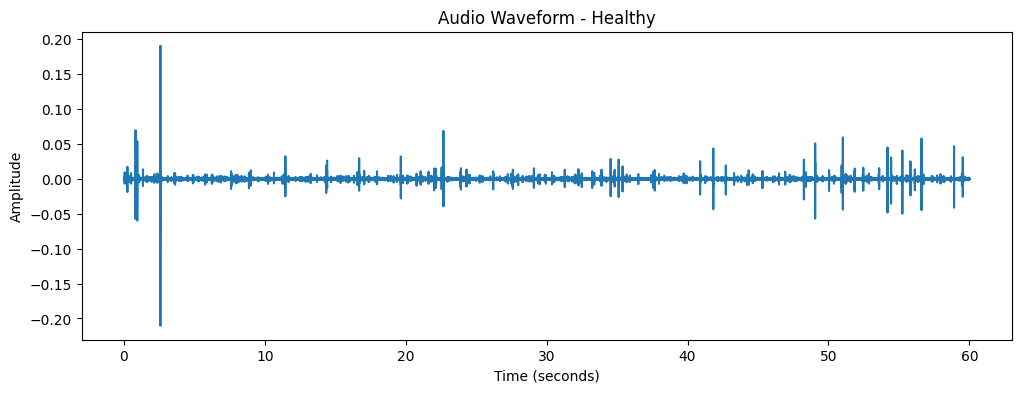

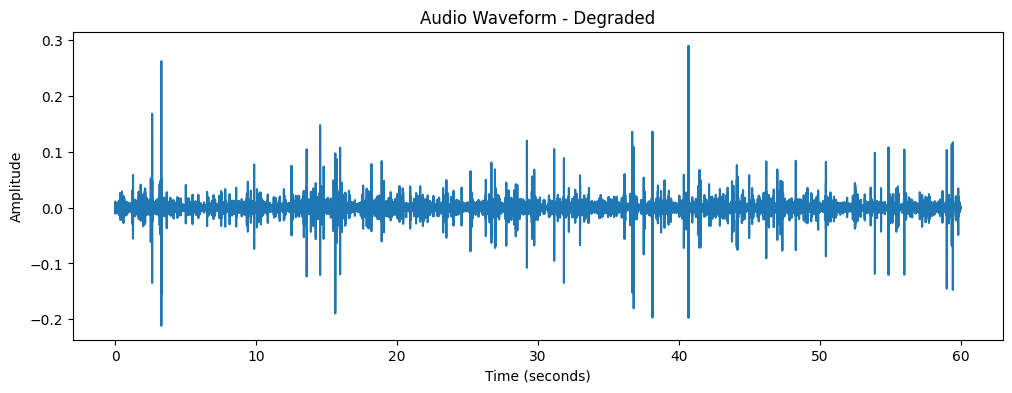

In [15]:
# Waveform and Spectrogram Functions 
def plot_waveform(audio, sr, title_suffix=""):
    """Plot the audio waveform with an optional title suffix."""
    time_axis = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio)
    title = "Audio Waveform" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()
    
if healthy_audio is not None:
    plot_waveform(healthy_audio, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    plot_waveform(degraded_audio, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

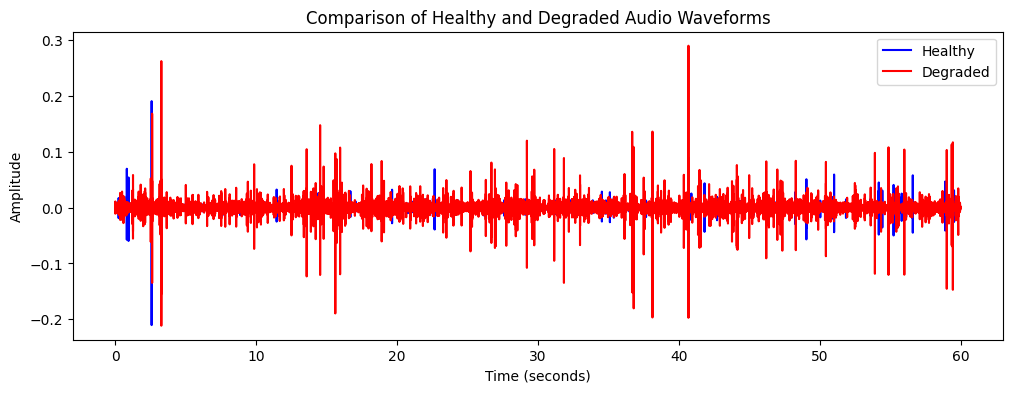

In [16]:
# Comparision Waveform
def plot_comparison_waveforms(healthy_audio, degraded_audio, sr):
    """
    Plot healthy and degraded audio waveforms on the same figure.
    
    Args:
        healthy_audio (np.ndarray): Audio array for healthy clip.
        degraded_audio (np.ndarray): Audio array for degraded clip.
        sr (int): Sample rate.
    """
    # Create time axes for each audio clip
    t_healthy = np.linspace(0, len(healthy_audio) / sr, len(healthy_audio))
    t_degraded = np.linspace(0, len(degraded_audio) / sr, len(degraded_audio))
    
    plt.figure(figsize=(12, 4))
    plt.plot(t_healthy, healthy_audio, label="Healthy", color='blue')
    plt.plot(t_degraded, degraded_audio, label="Degraded", color='red')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Comparison of Healthy and Degraded Audio Waveforms")
    plt.legend()
    plt.show()
if healthy_audio is not None and degraded_audio is not None:
    plot_comparison_waveforms(healthy_audio, degraded_audio, config.embed_fn_config.model_config.sample_rate)
else:
    print("One or both audio files could not be loaded.")


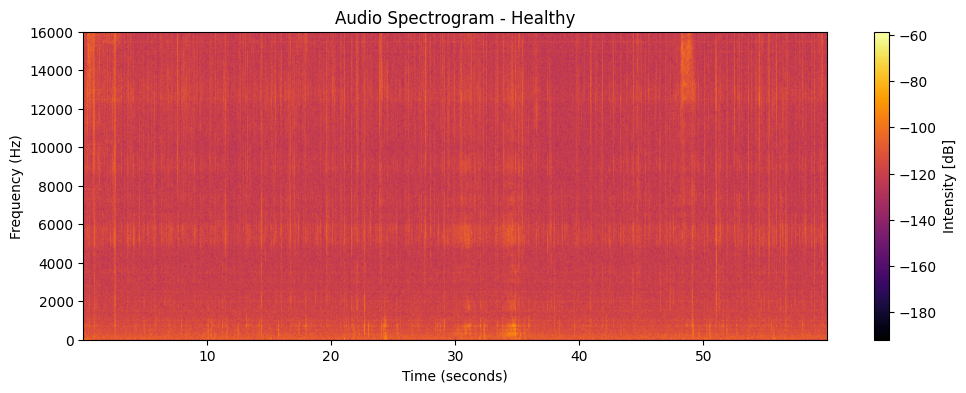

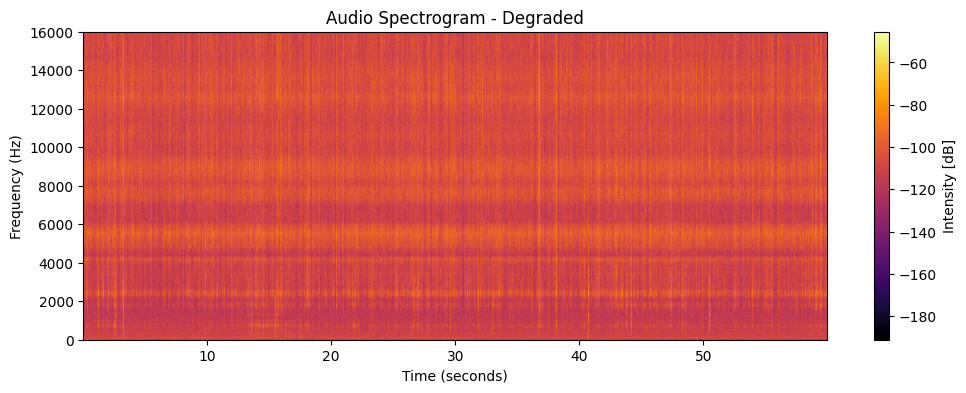

In [17]:
# Spectrogram Plot
def plot_spectrogram(audio, sr, n_fft=1024, hop_length=512, cmap='inferno', title_suffix=""):
    """Plot the spectrogram of the audio signal with an optional title suffix."""
    plt.figure(figsize=(12, 4))
    plt.specgram(audio, Fs=sr, NFFT=n_fft, noverlap=hop_length, cmap=cmap)
    title = "Audio Spectrogram" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity [dB]")
    plt.show()
    
if healthy_audio is not None:
    plot_spectrogram(healthy_audio, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    plot_spectrogram(degraded_audio, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

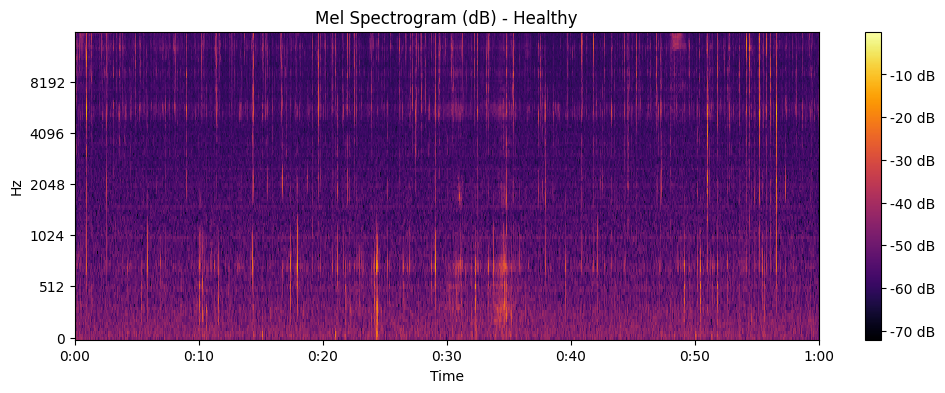

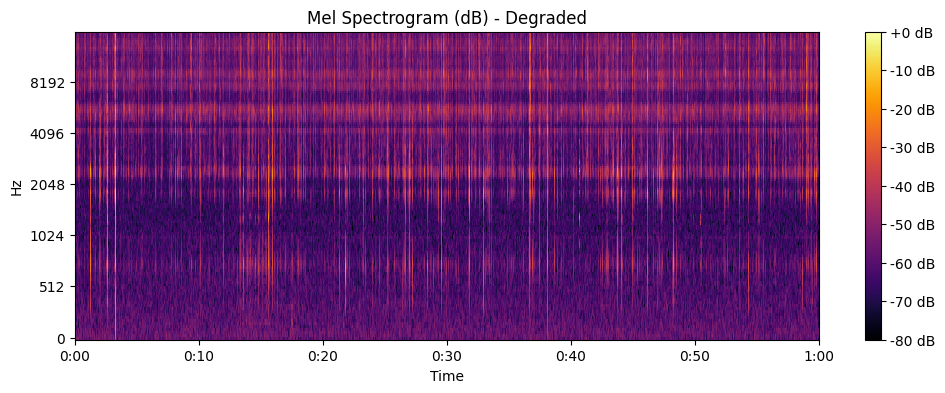

In [18]:
# Mel Spectrogram Function
# ---------------------------------------------
def compute_mel_spectrogram(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    """
    Compute a mel spectrogram from the audio signal and convert it to dB scale.
    
    Returns:
        S_dB: Mel spectrogram in decibel scale.
    """
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft,
                                       hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

def plot_mel_spectrogram(S_dB, sr, hop_length=512, title_suffix=""):
    """Plot the mel spectrogram with an optional title suffix."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='mel', cmap='inferno')
    title = "Mel Spectrogram (dB)" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
if healthy_audio is not None:
    # Compute the mel spectrogram in dB scale from healthy audio
    S_dB_healthy = compute_mel_spectrogram(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    # Plot the computed mel spectrogram for healthy audio with a title indicating "Healthy"
    plot_mel_spectrogram(S_dB_healthy, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    # Compute the mel spectrogram in dB scale from degraded audio
    S_dB_degraded = compute_mel_spectrogram(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    # Plot the computed mel spectrogram for degraded audio with a title indicating "Degraded"
    plot_mel_spectrogram(S_dB_degraded, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

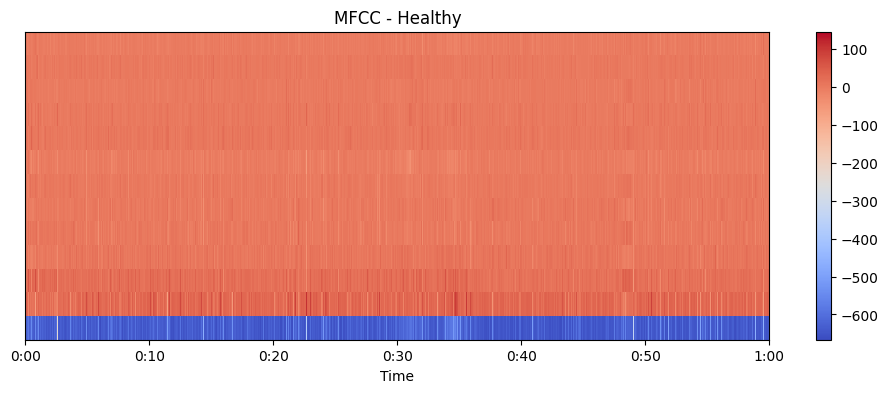

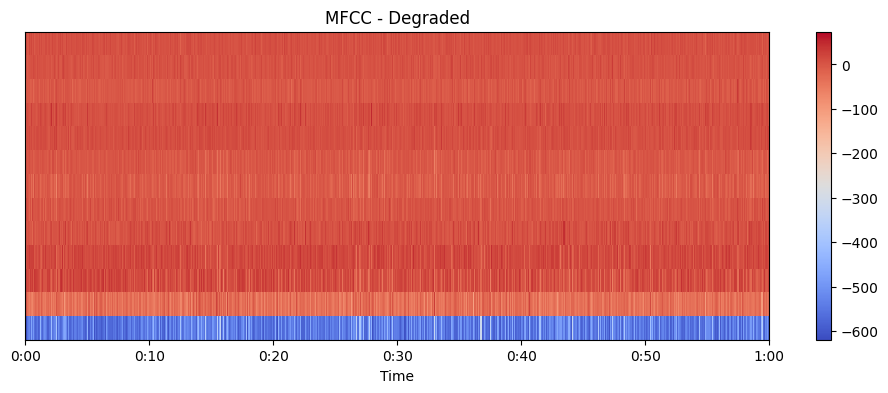

In [19]:
# MFCC Function
# ---------------------------------------------
def compute_mfcc(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    """
    Compute the Mel-Frequency Cepstral Coefficients (MFCCs) from the audio.
    
    Returns:
        mfccs: Array of MFCC features.
    """
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc,
                                 n_fft=n_fft, hop_length=hop_length)
    return mfccs

def plot_mfcc(mfccs, sr, hop_length=512, title_suffix=""):
    """Plot the MFCCs with an optional title suffix."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length, x_axis='time')
    title = "MFCC" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
if healthy_audio is not None:
    mfccs_healthy = compute_mfcc(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    plot_mfcc(mfccs_healthy, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    mfccs_degraded = compute_mfcc(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    plot_mfcc(mfccs_degraded, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

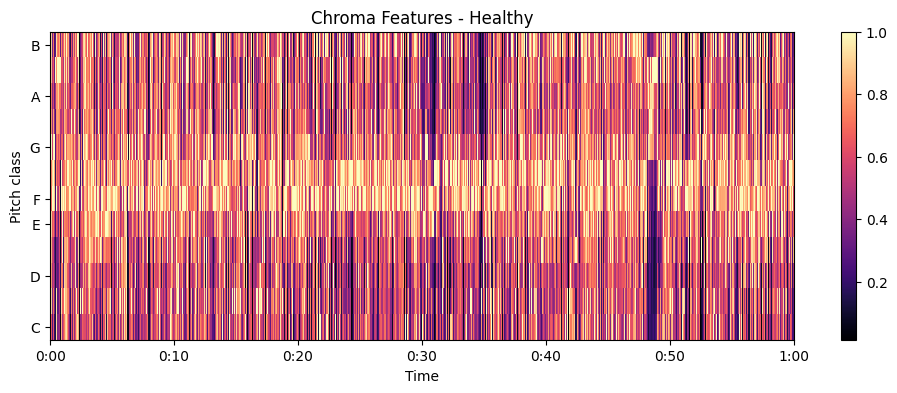

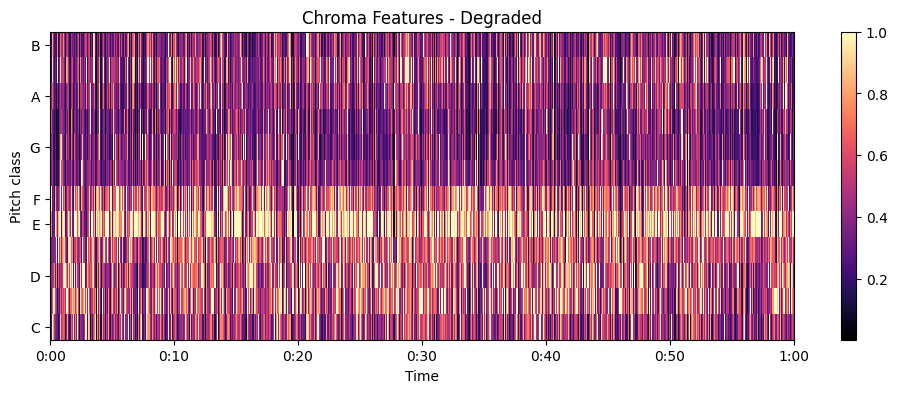

In [20]:
# Chroma Function
def compute_chroma(audio, sr, n_fft=2048, hop_length=512):
    """
    Compute chroma features from the audio signal.
    
    Returns:
        chroma: Chroma feature matrix.
    """
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr,
                                          n_fft=n_fft, hop_length=hop_length)
    return chroma

def plot_chroma(chroma, sr, hop_length=512, title_suffix=""):
    """Plot the chroma features with an optional title suffix."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='chroma')
    title = "Chroma Features" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
if healthy_audio is not None:
    # --- Chroma for Healthy Audio ---
    chroma_healthy = compute_chroma(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    plot_chroma(chroma_healthy, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    # --- Chroma for Degraded Audio ---
    chroma_degraded = compute_chroma(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    plot_chroma(chroma_degraded, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

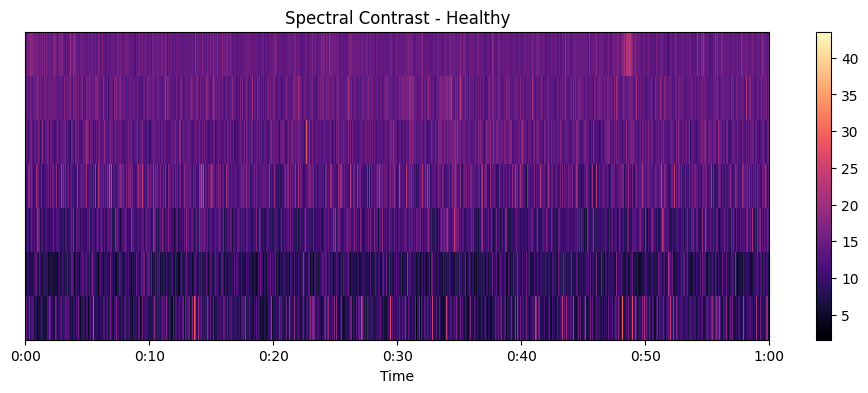

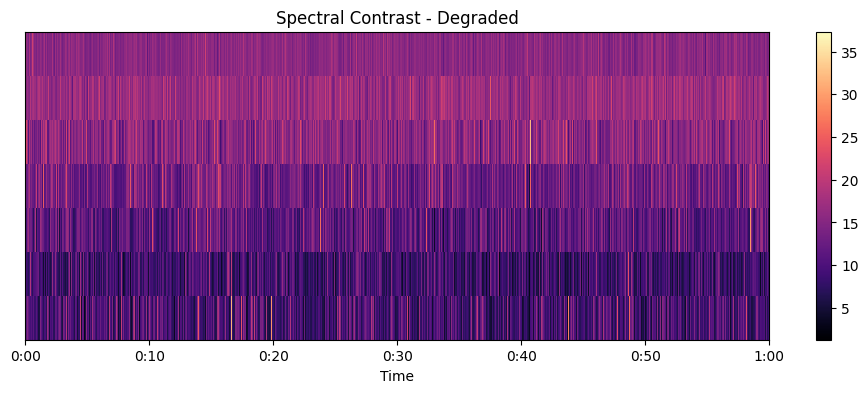

In [21]:
# Spectral Contrast
def compute_spectral_contrast(audio, sr, n_fft=2048, hop_length=512):
    """
    Compute the spectral contrast of the audio signal.
    
    Returns:
        contrast: Spectral contrast matrix.
    """
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr,
                                                 n_fft=n_fft, hop_length=hop_length)
    return contrast

def plot_spectral_contrast(contrast, sr, hop_length=512, title_suffix=""):
    """Plot the spectral contrast with an optional title suffix."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(contrast, sr=sr, hop_length=hop_length, x_axis='time')
    title = "Spectral Contrast" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
    
if healthy_audio is not None:
    # Compute spectral contrast for healthy audio
    contrast_healthy = compute_spectral_contrast(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    # Plot the spectral contrast with a title indicating "Healthy"
    plot_spectral_contrast(contrast_healthy, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    # Compute spectral contrast for degraded audio
    contrast_degraded = compute_spectral_contrast(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    # Plot the spectral contrast with a title indicating "Degraded"
    plot_spectral_contrast(contrast_degraded, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

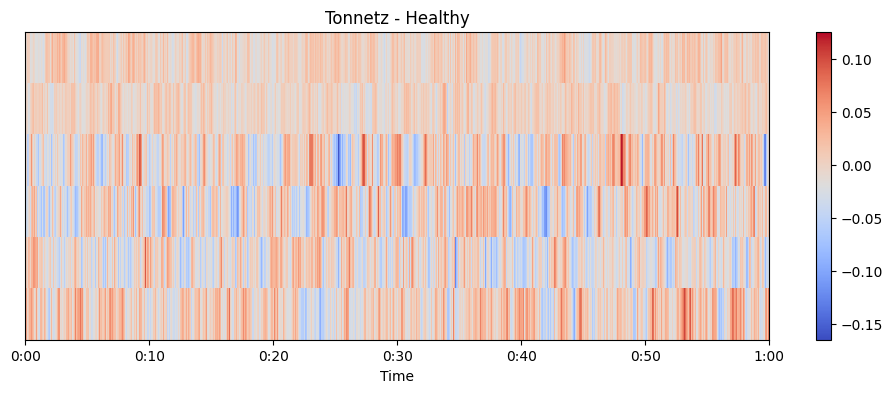

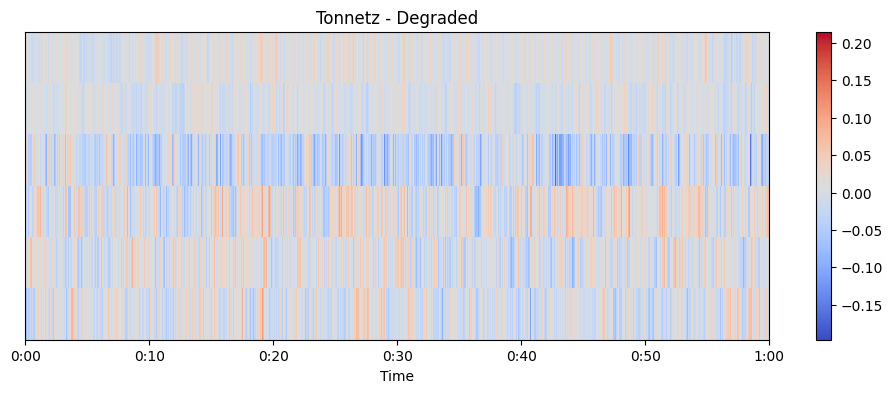

In [22]:
# Tonnetz Function
# ---------------------------------------------
def compute_tonnetz(audio, sr):
    """
    Compute the tonal centroid features (tonnetz) from the harmonic component.
    
    Returns:
        tonnetz: Tonnetz feature matrix.
    """
    y_harmonic = librosa.effects.harmonic(audio)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    return tonnetz

def plot_tonnetz(tonnetz, sr, hop_length=512, title_suffix=""):
    """Plot the tonnetz features with an optional title suffix."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(tonnetz, sr=sr, hop_length=hop_length, x_axis='time')
    title = "Tonnetz" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
if healthy_audio is not None:
    tonnetz_healthy = compute_tonnetz(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    plot_tonnetz(tonnetz_healthy, config.embed_fn_config.model_config.sample_rate, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    tonnetz_degraded = compute_tonnetz(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    plot_tonnetz(tonnetz_degraded, config.embed_fn_config.model_config.sample_rate, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

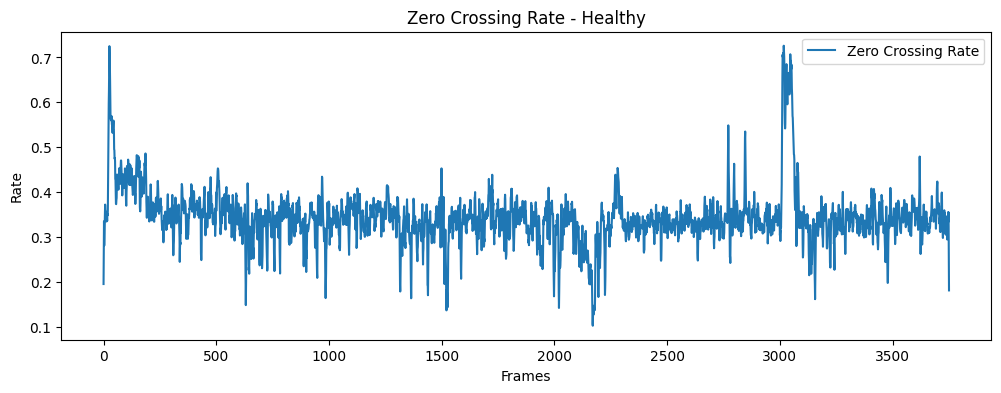

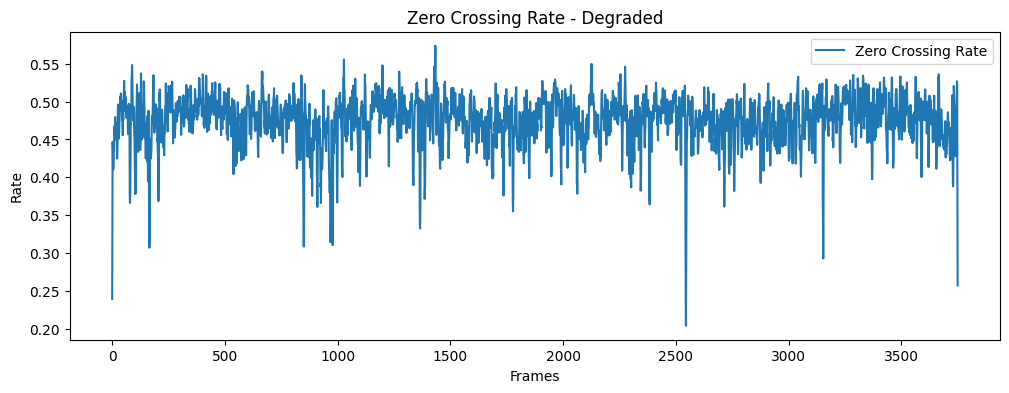

In [23]:
# Zero Crossing Rate
def compute_zero_crossing_rate(audio, sr, frame_length=2048, hop_length=512):
    """
    Compute the zero-crossing rate of the audio signal.
    
    Args:
        audio (np.ndarray): Audio time series.
        sr (int): Sample rate.
        frame_length (int): Number of samples in each analysis frame.
        hop_length (int): Number of samples between successive frames.
    
    Returns:
        zcr (np.ndarray): Zero-crossing rate for each frame (shape: (1, #frames)).
    """
    zcr = librosa.feature.zero_crossing_rate(
        y=audio, frame_length=frame_length, hop_length=hop_length
    )
    return zcr

def plot_zero_crossing_rate(zcr, title_suffix=""):
    """
    Plot the zero-crossing rate over time with an optional title suffix.
    
    Args:
        zcr (np.ndarray): Zero-crossing rate array, typically shape (1, #frames).
        title_suffix (str): A string appended to the title.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(zcr[0], label='Zero Crossing Rate')
    title = "Zero Crossing Rate" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel("Rate")
    plt.legend()
    plt.show()
    
if healthy_audio is not None:
    zcr_healthy = compute_zero_crossing_rate(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    plot_zero_crossing_rate(zcr_healthy, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    zcr_degraded = compute_zero_crossing_rate(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    plot_zero_crossing_rate(zcr_degraded, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")

In [25]:
# Spectral Centroid V1
"""
def compute_spectral_centroid(audio, sr, n_fft=2048, hop_length=512):

    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return centroid

def plot_spectral_centroid(audio, sr, centroid, hop_length=512, title_suffix=""):

    # Compute time axis for the centroid frames
    frames = range(len(centroid[0]))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    
    plt.figure(figsize=(12, 4))
    # Plot spectral centroid on a logarithmic scale
    plt.semilogy(t, centroid[0], label="Spectral Centroid (Hz)")
    
    # Optional: overlay the waveform (scaled for visualization)
    times = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.plot(times, 0.5 * np.max(centroid) * audio / np.max(audio), 
             color='gray', alpha=0.5, label="Waveform (scaled)")
    
    title = "Spectral Centroid Over Time" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz) (log scale)")
    plt.legend()
    plt.show()

# ---------------------------
# Usage for Healthy and Degraded Audio
# ---------------------------
if healthy_audio is not None:
    centroid_healthy = compute_spectral_centroid(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    plot_spectral_centroid(healthy_audio, config.embed_fn_config.model_config.sample_rate, centroid_healthy, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    centroid_degraded = compute_spectral_centroid(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    plot_spectral_centroid(degraded_audio, config.embed_fn_config.model_config.sample_rate, centroid_degraded, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")
    
"""

    


'\ndef compute_spectral_centroid(audio, sr, n_fft=2048, hop_length=512):\n\n    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)\n    return centroid\n\ndef plot_spectral_centroid(audio, sr, centroid, hop_length=512, title_suffix=""):\n\n    # Compute time axis for the centroid frames\n    frames = range(len(centroid[0]))\n    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)\n    \n    plt.figure(figsize=(12, 4))\n    # Plot spectral centroid on a logarithmic scale\n    plt.semilogy(t, centroid[0], label="Spectral Centroid (Hz)")\n    \n    # Optional: overlay the waveform (scaled for visualization)\n    times = np.linspace(0, len(audio) / sr, num=len(audio))\n    plt.plot(times, 0.5 * np.max(centroid) * audio / np.max(audio), \n             color=\'gray\', alpha=0.5, label="Waveform (scaled)")\n    \n    title = "Spectral Centroid Over Time" + (" - " + title_suffix if title_suffix else "")\n    plt.title(title)\n    plt.x

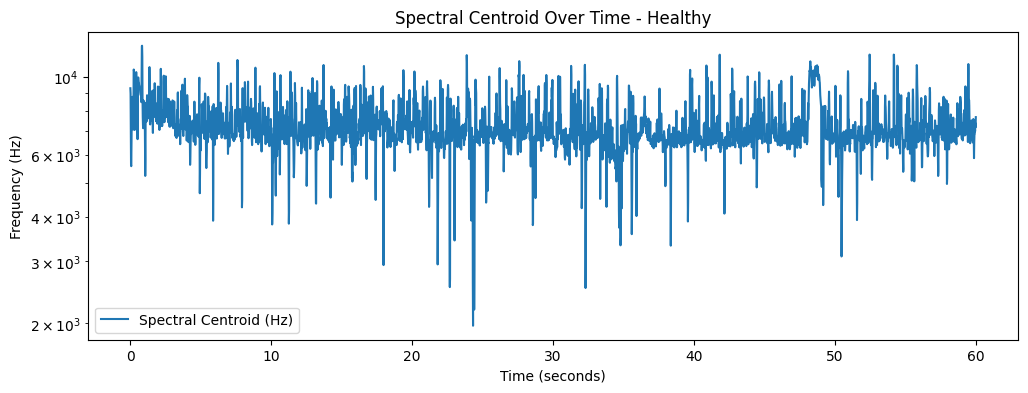

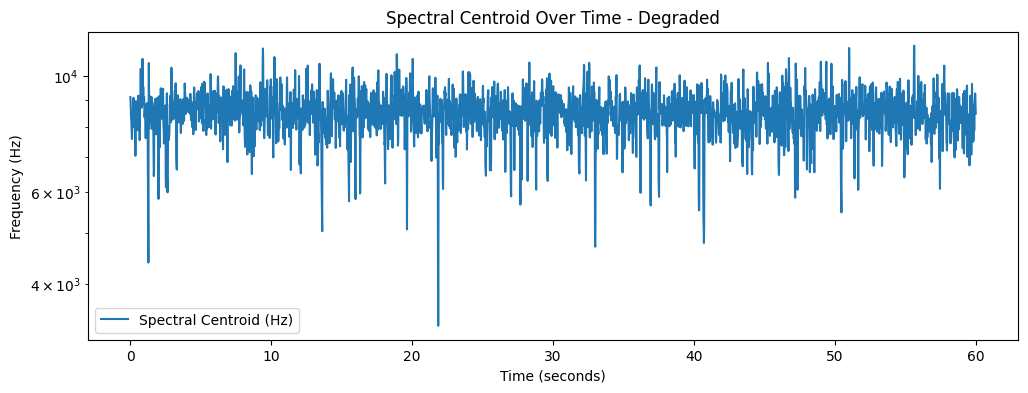

In [26]:
# Spectral Centroid V2
def compute_spectral_centroid(audio, sr, n_fft=2048, hop_length=512):
    """
    Compute the spectral centroid of the audio signal.
    
    Args:
        audio (np.ndarray): Audio time series.
        sr (int): Sample rate.
        n_fft (int): FFT window size.
        hop_length (int): Number of samples between successive frames.
    
    Returns:
        centroid (np.ndarray): Spectral centroid for each frame.
    """
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return centroid

def plot_spectral_centroid(audio, sr, centroid, hop_length=512, title_suffix=""):
    """
    Plot the spectral centroid over time (in Hz) with an optional title suffix.
    
    Args:
        audio (np.ndarray): Audio time series.
        sr (int): Sample rate.
        centroid (np.ndarray): Spectral centroid array.
        hop_length (int): Number of samples between successive frames.
        title_suffix (str): Text to append to the plot title.
    """
    # Compute time axis for the centroid frames
    frames = range(centroid.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    
    plt.figure(figsize=(12, 4))
    # Plot spectral centroid on a logarithmic scale
    plt.semilogy(t, centroid[0], label="Spectral Centroid (Hz)")
    
    title = "Spectral Centroid Over Time" + (" - " + title_suffix if title_suffix else "")
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.show()

# ---------------------------
# Usage for Healthy and Degraded Audio
# ---------------------------
if healthy_audio is not None:
    centroid_healthy = compute_spectral_centroid(healthy_audio, config.embed_fn_config.model_config.sample_rate)
    plot_spectral_centroid(healthy_audio, config.embed_fn_config.model_config.sample_rate,
                           centroid_healthy, title_suffix="Healthy")
else:
    print("Healthy audio file could not be loaded.")

if degraded_audio is not None:
    centroid_degraded = compute_spectral_centroid(degraded_audio, config.embed_fn_config.model_config.sample_rate)
    plot_spectral_centroid(degraded_audio, config.embed_fn_config.model_config.sample_rate,
                           centroid_degraded, title_suffix="Degraded")
else:
    print("Degraded audio file could not be loaded.")


In [ ]:
#Original
def safe_load_audio_embeddings(filepath: str, sample_rate: int):
    try:
        # Load the audio file as is
        audio, sr = librosa.load(filepath, sr=sample_rate)
        return audio
    except (librosa.util.exceptions.ParameterError, sf.LibsndfileError, EOFError, aifc.Error) as e:
        print(f"Skipping file {filepath}: {str(e)}")
        return None
    except Exception as e:
        # Catch any other exceptions that might occur
        print(f"Unexpected error for file {filepath}: {str(e)}")
        return None

In [57]:
# FINALISE HZ FILTER
# CHOOSE HOW TO REPRESENT AUDIO

def safe_load_audio_embeddings_mel(filepath: str, sample_rate: int, n_mels: int = 128):
    try:
        # Load the audio file with the given sample rate
        audio, sr = librosa.load(filepath, sr=sample_rate)
        # Compute the mel spectrogram from the audio signal
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        # Convert the mel spectrogram to decibel (dB) units for better scaling
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except (librosa.util.exceptions.ParameterError, sf.LibsndfileError, EOFError, aifc.Error) as e:
        print(f"Skipping file {filepath}: {str(e)}")
        return None
    except Exception as e:
        print(f"Unexpected error for file {filepath}: {str(e)}")
        return None


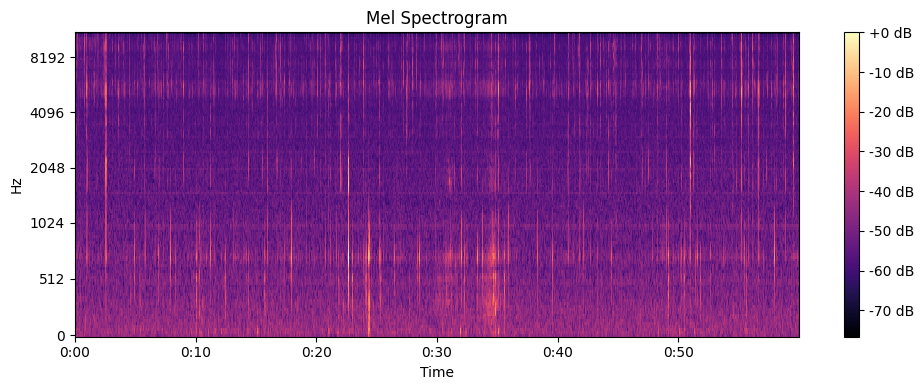

In [58]:
# Specify the file path and sample rate
filepath = '/mnt/f/mars_global_acoustic_study/maldives_acoustics/H1_M2/20211118_095200.WAV'
sample_rate = 22050

# Load the mel spectrogram for the given file
mel_spectrogram = safe_load_audio_embeddings_mel(filepath, sample_rate)

if mel_spectrogram is not None:
    # Plot the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
else:
    print("The file could not be processed.")

In [59]:
# Set up the audio loader function for the main loop
audio_loader = lambda fp, offset: safe_load_audio_embeddings_mel(fp, config.embed_fn_config.model_config.sample_rate)

# Initialize counters for successful, failed, and skipped files
succ, fail, skipped = 0, 0, 0

# Initialize audio_iterator to None
audio_iterator = None


In [60]:
audio_loader

<function __main__.<lambda>(fp, offset)>

In [61]:
source_infos

[SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_162400.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_162800.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_163200.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_163600.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_164000.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_164400.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211023_164800.WAV', shard_num=0, shard_len_s=-1.0),
 SourceInfo(filepath='/mnt/f/mars_global_acoustic_study

In [63]:
try:
    # Use source_infos for audio iterator
    audio_iterator = audio_utils.multi_load_audio_window(
        filepaths=[s.filepath for s in source_infos],
        offsets=[s.shard_num * s.shard_len_s for s in source_infos],
        audio_loader=audio_loader,
    )

    # Adding progress bar for processing source_infos
    with tqdm.tqdm(total=len(source_infos), desc="Processing embeddings") as pbar:
        with tf_examples.EmbeddingsTFRecordMultiWriter(
            output_dir=output_dir, num_files=config.get('tf_record_shards', 1)) as file_writer:
            
            for source_info, audio in zip(source_infos, audio_iterator):
                file_id = source_info.file_id(config.embed_fn_config.file_id_depth)
                offset_s = source_info.shard_num * source_info.shard_len_s
                if audio is None:
                    skipped += 1
                    pbar.update(1)
                    continue
                example = embed_fn.audio_to_example(file_id, offset_s, audio)
                if example is None:
                    fail += 1
                    pbar.update(1)
                    continue
                file_writer.write(example.SerializeToString())
                succ += 1
                pbar.update(1)
            file_writer.flush()
finally:
    # Only delete audio_iterator if it was defined
    if audio_iterator is not None:
        del (audio_iterator)

# Print summary of processing results
print(f'\n\nSuccessfully processed {succ} source_infos.')
print(f'Failed to process {fail} source_infos.')
print(f'Skipped {skipped} files due to errors.')

Processing embeddings:  20%|██        | 11751/58525 [29:51<2:47:54,  4.64it/s]

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_083200.WAV: 


Processing embeddings:  20%|██        | 11752/58525 [29:51<2:46:50,  4.67it/s]

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_092400.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_094000.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_093200.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_102000.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_101200.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_102800.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_110400.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_111600.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_112800.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D1_M3/20211125_122800.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/ma

Processing embeddings:  21%|██        | 12000/58525 [30:26<1:47:51,  7.19it/s]

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D2_M5/20211025_192800.WAV: 


Processing embeddings:  21%|██        | 12155/58525 [30:50<2:21:42,  5.45it/s]

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D2_M5/20211026_085600.WAV: 


Processing embeddings:  21%|██        | 12258/58525 [31:07<3:10:51,  4.04it/s]

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D2_M5/20211027_095200.WAV: 


Processing embeddings:  21%|██        | 12306/58525 [31:14<2:57:58,  4.33it/s]

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/D2_M5/20211028_113200.WAV: 


Processing embeddings:  80%|███████▉  | 46703/58525 [1:58:38<35:17,  5.58it/s]  

Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/H2_M4/20211125_180800.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/H2_M4/20211125_194800.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/H2_M4/20211125_200400.WAV: 
Skipping file /mnt/f/mars_global_acoustic_study/maldives_acoustics/H2_M4/20211125_202800.WAV: 


Processing embeddings: 100%|██████████| 58525/58525 [2:28:04<00:00,  6.59it/s]  



Successfully processed 65355 source_infos.
Failed to process 0 source_infos.
Skipped 23 files due to errors.
